In [2]:
# Установка зависимостей
!pip install torch torchvision matplotlib numpy pandas adversarial-robustness-toolbox tqdm -q

import os
import warnings
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import GTSRB  # встроен в torchvision >= 0.12
from torchvision.models import vgg16, resnet50
from tqdm import tqdm  # красивые прогресс-бары
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")  # убираем предупреждения от ART/PIL
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")

Используем устройство: cuda


In [3]:
data_root = "./gtsrb"
# Трансформации: приводим к 32×32 и нормализуем под ImageNet (т.к. модели предобучены на нём)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загрузка полных train/test
train_dataset = GTSRB(root=data_root, split='train', transform=transform, download=True)
test_dataset = GTSRB(root=data_root, split='test', transform=transform, download=True)

# Подмножества:
attack_1000 = Subset(test_dataset, range(1000))  # первые 1000 — для нецелевых атак
stop_indices = [i for i, (_, label) in enumerate(test_dataset) if label == 14][:270]  # класс "Стоп"
stop_subset = Subset(test_dataset, stop_indices)  # 270 изображений — для целевой атаки

# DataLoader'ы для эффективной загрузки на GPU
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # используем test как val
attack_loader = DataLoader(attack_1000, batch_size=batch_size, shuffle=False)
stop_loader = DataLoader(stop_subset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)} изображений")
print(f"Test: {len(test_dataset)} изображений")
print(f"Для атак: {len(attack_1000)} изображений")
print(f"Знаков 'Стоп': {len(stop_subset)} изображений")

100%|██████████| 187M/187M [00:14<00:00, 13.0MB/s]
100%|██████████| 89.0M/89.0M [00:11<00:00, 7.90MB/s]
100%|██████████| 99.6k/99.6k [00:00<00:00, 184kB/s]


Train: 26640 изображений
Test: 12630 изображений
Для атак: 1000 изображений
Знаков 'Стоп': 270 изображений


In [4]:
def get_model(name, num_classes=43):
    """
    Загружает предобученную модель (ImageNet) и заменяет последний слой под 43 класса GTSRB.
    """
    if name == "VGG16":
        model = vgg16(weights="IMAGENET1K_V1")
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name == "ResNet50":
        model = resnet50(weights="IMAGENET1K_V2")
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError("Поддерживаются только VGG16 и ResNet50")
    return model.to(device)

def train_model(model_name, epochs=5):
    """
    Обучает модель с Adam-оптимизатором. Возвращает модель, историю потерь и точности.
    """
    model = get_model(model_name)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)  # можно подбирать lr
    train_losses, val_accs = [], []

    for epoch in range(epochs):
        # Обучение
        model.train()
        total_loss = 0
        for x, y in tqdm(train_loader, desc=f"{model_name} Эпоха {epoch+1}/{epochs}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        # Валидация (на тестовом множестве)
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x).argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        val_accs.append(100 * correct / total)
    return model, train_losses, val_accs

def dataloader_to_numpy(loader):
    """
    Конвертирует DataLoader в numpy-массивы (требуется для ART).
    """
    xs, ys = [], []
    for x, y in loader:
        xs.append(x.numpy())
        ys.append(y.numpy())
    return np.concatenate(xs), np.concatenate(ys)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 110MB/s] 
VGG16 Эпоха 5/5: 100%|██████████| 417/417 [00:43<00:00,  9.54it/s]


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]
ResNet50 Эпоха 5/5: 100%|██████████| 417/417 [00:33<00:00, 12.43it/s]


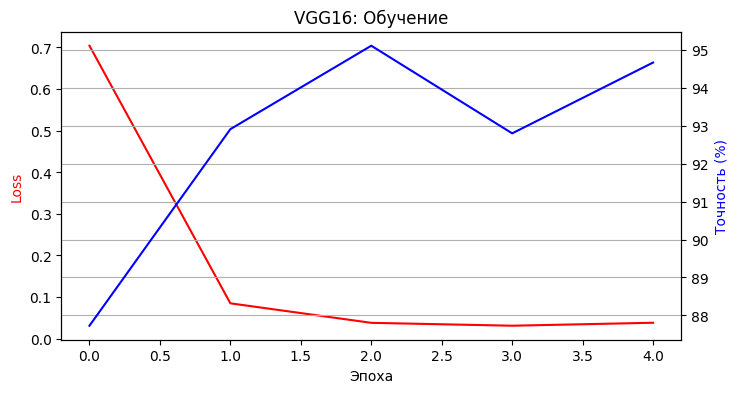

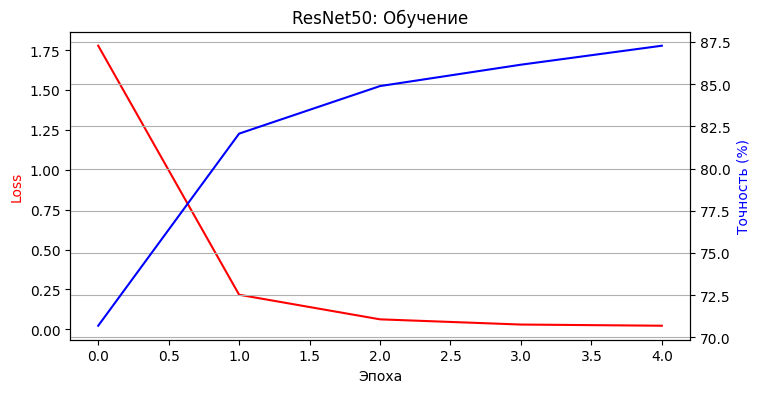

In [5]:
# Обучение VGG16
vgg_model, vgg_loss, vgg_acc = train_model("VGG16", epochs=5)
torch.save(vgg_model.state_dict(), "vgg16_gtsrb.pth")

# Обучение ResNet50
res_model, res_loss, res_acc = train_model("ResNet50", epochs=5)
torch.save(res_model.state_dict(), "resnet50_gtsrb.pth")

# Графики потерь и точности (Рис. 2)
def plot_metrics(loss, acc, title):
    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax1.plot(loss, 'r-', label='Loss')
    ax1.set_xlabel('Эпоха'); ax1.set_ylabel('Loss', color='r')
    ax2 = ax1.twinx()
    ax2.plot(acc, 'b-', label='Accuracy')
    ax2.set_ylabel('Точность (%)', color='b')
    plt.title(title); plt.grid(True); plt.show()

plot_metrics(vgg_loss, vgg_acc, "VGG16: Обучение")
plot_metrics(res_loss, res_acc, "ResNet50: Обучение")

In [6]:
#Конвертирует подмножества в numpy — формат, понятный ART.
x_clean_1000, y_clean_1000 = dataloader_to_numpy(attack_loader)  # для нецелевых атак
x_stop, y_stop = dataloader_to_numpy(stop_loader)               # для целевых атак
y_target_30 = np.full_like(y_stop, 1)  # целевой класс: "Ограничение 30" → метка 1

In [7]:
#ART не работает напрямую с torch.nn.Module — нужна обёртка.
from art.estimators.classification import PyTorchClassifier

def make_art_classifier(pytorch_model, nb_classes=43):
    pytorch_model.eval()  # важно: модель должна быть в eval-режиме!
    return PyTorchClassifier(
        model=pytorch_model,
        clip_values=(0, 1),  # значения пикселей в [0,1]
        loss=nn.CrossEntropyLoss(),
        optimizer=optim.Adam(pytorch_model.parameters()),
        input_shape=(3, 32, 32),
        nb_classes=nb_classes,
        device_type="gpu" if torch.cuda.is_available() else "cpu"
    )

art_vgg = make_art_classifier(vgg_model)
art_res = make_art_classifier(res_model)


In [8]:
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent

epsilons = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

def run_untargeted_attacks(art_model, x, y, eps_list):
    """
    Выполняет нецелевые FGSM и PGD атаки, возвращает точность при каждом ε.
    """
    results = {"FGSM": [], "PGD": []}
    for eps in eps_list:
        # FGSM: однократный шаг в направлении градиента
        fgsm = FastGradientMethod(art_model, eps=eps)
        acc_fgsm = (art_model.predict(fgsm.generate(x)).argmax(1) == y).mean() * 100
        results["FGSM"].append(acc_fgsm)

        # PGD: итеративная версия FGSM с проекцией в L∞-шар
        pgd = ProjectedGradientDescent(art_model, eps=eps, eps_step=eps/10, max_iter=20)
        acc_pgd = (art_model.predict(pgd.generate(x)).argmax(1) == y).mean() * 100
        results["PGD"].append(acc_pgd)

        print(f"ε={eps:.3f} → FGSM: {acc_fgsm:.1f}%, PGD: {acc_pgd:.1f}%")
    return results

# Запуск атак
vgg_results = run_untargeted_attacks(art_vgg, x_clean_1000, y_clean_1000, epsilons)
res_results = run_untargeted_attacks(art_res, x_clean_1000, y_clean_1000, epsilons)

PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.004 → FGSM: 94.7%, PGD: 94.7%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.008 → FGSM: 94.8%, PGD: 94.8%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.012 → FGSM: 94.8%, PGD: 94.7%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.016 → FGSM: 94.6%, PGD: 94.5%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.020 → FGSM: 94.3%, PGD: 94.2%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.031 → FGSM: 94.8%, PGD: 93.9%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.039 → FGSM: 94.3%, PGD: 93.8%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.078 → FGSM: 92.3%, PGD: 88.2%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.196 → FGSM: 82.5%, PGD: 66.9%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.314 → FGSM: 75.1%, PGD: 52.1%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.004 → FGSM: 87.0%, PGD: 86.8%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.008 → FGSM: 86.5%, PGD: 86.3%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.012 → FGSM: 86.4%, PGD: 85.9%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.016 → FGSM: 86.2%, PGD: 85.0%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.020 → FGSM: 85.3%, PGD: 84.5%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.031 → FGSM: 84.8%, PGD: 82.5%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.039 → FGSM: 83.7%, PGD: 80.9%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.078 → FGSM: 80.4%, PGD: 71.3%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.196 → FGSM: 76.2%, PGD: 52.9%


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ε=0.314 → FGSM: 73.8%, PGD: 42.5%


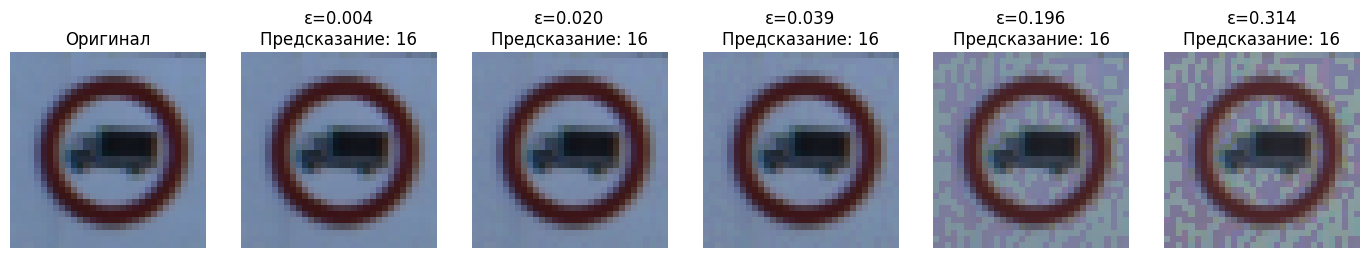

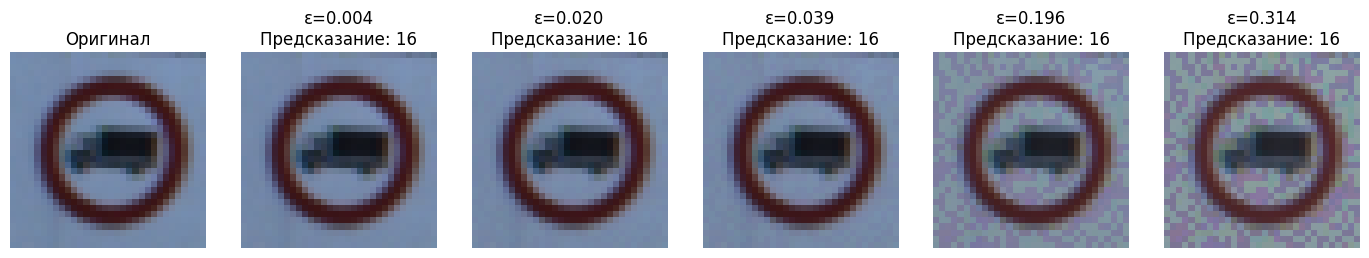

In [9]:
# оригинальное и adversarial изображения с предсказаниями.
def denormalize(x):
    """Отменяет нормализацию ImageNet для корректного отображения."""
    mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)
    return np.clip(x * std + mean, 0, 1)

def show_fgsm_examples(art_model, x_clean, eps_list=[1/255,5/255,10/255,50/255,80/255], idx=0):
    fig, ax = plt.subplots(1, len(eps_list)+1, figsize=(14, 2.5))
    ax[0].imshow(denormalize(x_clean[idx]).transpose(1,2,0))
    ax[0].set_title("Оригинал"); ax[0].axis("off")
    for i, eps in enumerate(eps_list):
        fgsm = FastGradientMethod(art_model, eps=eps)
        x_adv = fgsm.generate(x_clean[idx:idx+1])
        pred = art_model.predict(x_adv).argmax()
        ax[i+1].imshow(denormalize(x_adv[0]).transpose(1,2,0))
        ax[i+1].set_title(f"ε={eps:.3f}\nПредсказание: {pred}")
        ax[i+1].axis("off")
    plt.tight_layout(); plt.show()

show_fgsm_examples(art_vgg, x_clean_1000, idx=0)
show_fgsm_examples(art_res, x_clean_1000, idx=0)

In [10]:
def run_targeted_attacks(art_model, x_clean, y_target, eps_list):
    """
    Целевая атака: модель должна предсказать y_target.
    """
    pgd_rates, fgsm_rates = [], []
    for eps in eps_list:
        # PGD (целевая)
        pgd = ProjectedGradientDescent(art_model, eps=eps, eps_step=eps/10, max_iter=20, targeted=True)
        x_adv = pgd.generate(x_clean, y=y_target)
        pgd_success = (art_model.predict(x_adv).argmax(1) == y_target).mean() * 100
        pgd_rates.append(pgd_success)

        # FGSM (целевая)
        fgsm = FastGradientMethod(art_model, eps=eps, targeted=True)
        x_adv = fgsm.generate(x_clean, y=y_target)
        fgsm_success = (art_model.predict(x_adv).argmax(1) == y_target).mean() * 100
        fgsm_rates.append(fgsm_success)

        print(f"ε={eps:.3f} → PGD: {pgd_success:.1f}%, FGSM: {fgsm_success:.1f}%")
    return pgd_rates, fgsm_rates

eps_target = [1/255, 3/255, 5/255, 10/255, 20/255, 50/255, 80/255]
pgd_vgg, fgsm_vgg = run_targeted_attacks(art_vgg, x_stop, y_target_30, eps_target)
pgd_res, fgsm_res = run_targeted_attacks(art_res, x_stop, y_target_30, eps_target)

PGD - Batches:   0%|          | 0/9 [00:00<?, ?it/s]

ε=0.004 → PGD: 0.7%, FGSM: 0.7%


PGD - Batches:   0%|          | 0/9 [00:00<?, ?it/s]

ε=0.012 → PGD: 0.7%, FGSM: 0.7%


PGD - Batches:   0%|          | 0/9 [00:00<?, ?it/s]

ε=0.020 → PGD: 0.7%, FGSM: 0.7%


PGD - Batches:   0%|          | 0/9 [00:00<?, ?it/s]

ε=0.039 → PGD: 0.7%, FGSM: 0.7%


PGD - Batches:   0%|          | 0/9 [00:00<?, ?it/s]

ε=0.078 → PGD: 2.2%, FGSM: 1.5%


PGD - Batches:   0%|          | 0/9 [00:00<?, ?it/s]

ε=0.196 → PGD: 28.9%, FGSM: 3.3%


PGD - Batches:   0%|          | 0/9 [00:00<?, ?it/s]

ε=0.314 → PGD: 53.0%, FGSM: 5.6%


PGD - Batches:   0%|          | 0/9 [00:00<?, ?it/s]

ε=0.004 → PGD: 0.4%, FGSM: 0.4%


PGD - Batches:   0%|          | 0/9 [00:00<?, ?it/s]

ε=0.012 → PGD: 0.7%, FGSM: 0.4%


PGD - Batches:   0%|          | 0/9 [00:00<?, ?it/s]

ε=0.020 → PGD: 0.7%, FGSM: 0.7%


PGD - Batches:   0%|          | 0/9 [00:00<?, ?it/s]

ε=0.039 → PGD: 2.2%, FGSM: 1.1%


PGD - Batches:   0%|          | 0/9 [00:00<?, ?it/s]

ε=0.078 → PGD: 5.9%, FGSM: 1.1%


PGD - Batches:   0%|          | 0/9 [00:00<?, ?it/s]

ε=0.196 → PGD: 25.2%, FGSM: 0.7%


PGD - Batches:   0%|          | 0/9 [00:00<?, ?it/s]

ε=0.314 → PGD: 44.1%, FGSM: 1.5%


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

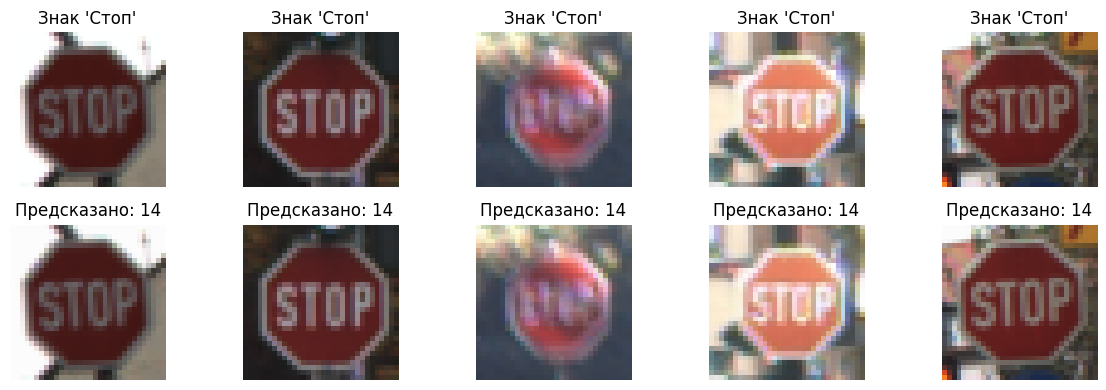

In [11]:
# Визуализация целевых атак 5 пар "Стоп → Speed 30".
def show_targeted_examples(art_model, x_clean, y_target, eps=10/255, n=5):
    pgd = ProjectedGradientDescent(art_model, eps=eps, eps_step=eps/10, max_iter=20, targeted=True)
    x_adv = pgd.generate(x_clean[:n], y=y_target[:n])
    fig, ax = plt.subplots(2, n, figsize=(12, 4))
    for i in range(n):
        ax[0,i].imshow(denormalize(x_clean[i]).transpose(1,2,0))
        ax[0,i].set_title("Знак 'Стоп'"); ax[0,i].axis("off")
        pred = art_model.predict(x_adv[i:i+1]).argmax()
        ax[1,i].imshow(denormalize(x_adv[i]).transpose(1,2,0))
        ax[1,i].set_title(f"Предсказано: {pred}"); ax[1,i].axis("off")
    plt.tight_layout(); plt.show()

show_targeted_examples(art_vgg, x_stop, y_target_30, eps=10/255)

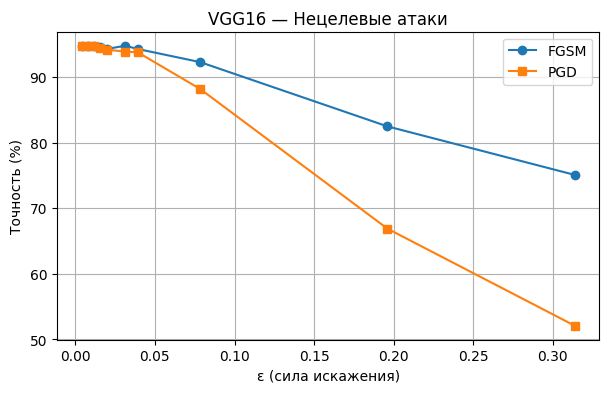

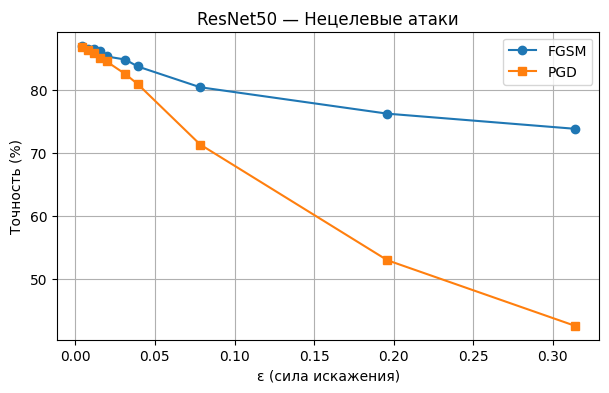

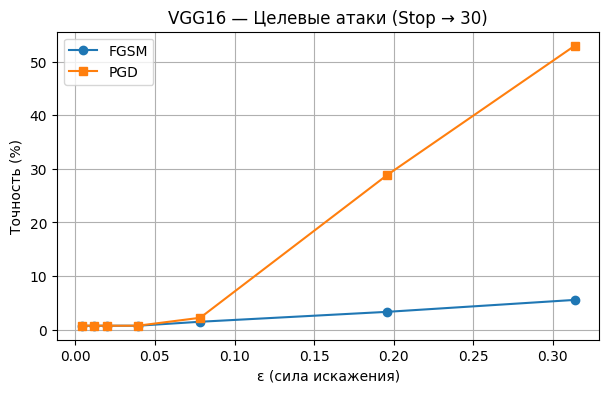

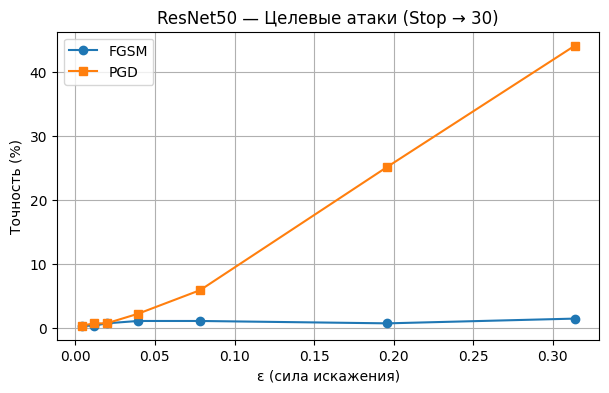

In [12]:
# Графики зависимости точности от ε.
def plot_accuracy_curves(eps, fgsm, pgd, title):
    plt.figure(figsize=(7,4))
    plt.plot(eps, fgsm, 'o-', label='FGSM')
    plt.plot(eps, pgd, 's-', label='PGD')
    plt.xlabel('ε (сила искажения)')
    plt.ylabel('Точность (%)')
    plt.title(title)
    plt.legend(); plt.grid(True)
    plt.show()

# Нецелевые
plot_accuracy_curves(epsilons, vgg_results["FGSM"], vgg_results["PGD"], "VGG16 — Нецелевые атаки")
plot_accuracy_curves(epsilons, res_results["FGSM"], res_results["PGD"], "ResNet50 — Нецелевые атаки")

# Целевые
plot_accuracy_curves(eps_target, fgsm_vgg, pgd_vgg, "VGG16 — Целевые атаки (Stop → 30)")
plot_accuracy_curves(eps_target, fgsm_res, pgd_res, "ResNet50 — Целевые атаки (Stop → 30)")